## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l1, l2, l1_l2
from collections import defaultdict
import matplotlib.pyplot as plt

#%matplotlib inline

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=False):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_data_shape, dropout_rate, l2_rate):
    model = Sequential()
    
    #卷積層1與池化層1
    model.add(Conv2D(filters=1024, kernel_size=(3, 3), input_shape=input_data_shape, padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層2與池化層2
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層3與池化層3
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層4與池化層4
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層4與池化層5
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))
              
    #建立神經網路(平坦層、隱藏層、輸出層)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(10, activation='softmax', kernel_regularizer=l2(l2_rate)))

    return model

In [6]:
## 超參數設定
# OPTIMIZER = ["sgd", "rmsprop", "adam", "adagrad"]
OPTIMIZER = ["adam"]
LEARNING_RATE = 1e-3
L2_EXP = 1e-4
DROPOUT = [0.1, 0.2, 0.3]
EPOCHS = 150
BATCH_SIZE = 64
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
earlystop = EarlyStopping(monitor="val_loss", 
                          patience=50, 
                          verbose=1
                          )

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

In [8]:
tra_loss = defaultdict(list)
val_loss = defaultdict(list)
tra_accu = defaultdict(list)
val_accu = defaultdict(list)

for i, drop_rate in enumerate(DROPOUT):
    for j, optr in enumerate(OPTIMIZER):
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Optimizer=%s, ls=%.6f, dr=%.2f, bs=%d" % (optr, LEARNING_RATE, drop_rate, BATCH_SIZE))
        
        # create model
        model = build_mlp(x_train.shape[1:], drop_rate, L2_EXP)
        
        # optimizer
        if optr == "sgd":
            optimizer = optimizers.SGD(lr=LEARNING_RATE, decay=1e-6, momentum=MOMENTUM, nesterov=True)

        if optr == "rmsprop":
            optimizer = optimizers.RMSprop(lr=LEARNING_RATE, rho=0.9, epsilon=None, decay=0.0)

        if optr == "adam":
            optimizer = optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

        if optr == "adagrad":
            optimizer = optimizers.Adagrad(lr=LEARNING_RATE, epsilon=None, decay=0.0)
    
        # compile model and training
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True, 
                  callbacks=[earlystop, model_ckpt, reduce_lr])

        # Collect results
        exp_tag = "%s:%s" % (("exp_"+str(i)), str(optr))
        tra_loss[exp_tag].append(model.history.history["loss"])
        val_loss[exp_tag].append(model.history.history["val_loss"])
        
        tra_accu[exp_tag].append(model.history.history["acc"])
        val_accu[exp_tag].append(model.history.history["val_acc"])


Experiment with Optimizer=adam, ls=0.001000, dr=0.10, bs=64
Train on 50000 samples, validate on 10000 samples
Epoch 1/150
50000/50000 [==============================] - 268s 5ms/step - loss: 1.3933 - acc: 0.5222 - val_loss: 2.1356 - val_acc: 0.3302
Epoch 2/150
50000/50000 [==============================] - 263s 5ms/step - loss: 0.9257 - acc: 0.6910 - val_loss: 1.2026 - val_acc: 0.5963
Epoch 3/150
50000/50000 [==============================] - 263s 5ms/step - loss: 0.7365 - acc: 0.7590 - val_loss: 0.9734 - val_acc: 0.6922
Epoch 4/150
50000/50000 [==============================] - 263s 5ms/step - loss: 0.6054 - acc: 0.8032 - val_loss: 0.8802 - val_acc: 0.7339
Epoch 5/150
50000/50000 [==============================] - 263s 5ms/step - loss: 0.5048 - acc: 0.8374 - val_loss: 0.8094 - val_acc: 0.7470
Epoch 6/150
50000/50000 [==============================] - 263s 5ms/step - loss: 0.4190 - acc: 0.8648 - val_loss: 0.9262 - val_acc: 0.7421
Epoch 7/150
50000/50000 [==============================]

50000/50000 [==============================] - 262s 5ms/step - loss: 0.0223 - acc: 0.9959 - val_loss: 0.9674 - val_acc: 0.8360

Epoch 00048: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 49/150
50000/50000 [==============================] - 262s 5ms/step - loss: 0.0227 - acc: 0.9957 - val_loss: 0.9678 - val_acc: 0.8352
Epoch 50/150
50000/50000 [==============================] - 262s 5ms/step - loss: 0.0230 - acc: 0.9955 - val_loss: 0.9651 - val_acc: 0.8361
Epoch 51/150
50000/50000 [==============================] - 262s 5ms/step - loss: 0.0217 - acc: 0.9963 - val_loss: 0.9674 - val_acc: 0.8368
Epoch 52/150
50000/50000 [==============================] - 262s 5ms/step - loss: 0.0229 - acc: 0.9957 - val_loss: 0.9687 - val_acc: 0.8377
Epoch 53/150
50000/50000 [==============================] - 262s 5ms/step - loss: 0.0212 - acc: 0.9963 - val_loss: 0.9706 - val_acc: 0.8365

Epoch 00053: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 54/15

## Plot loss history

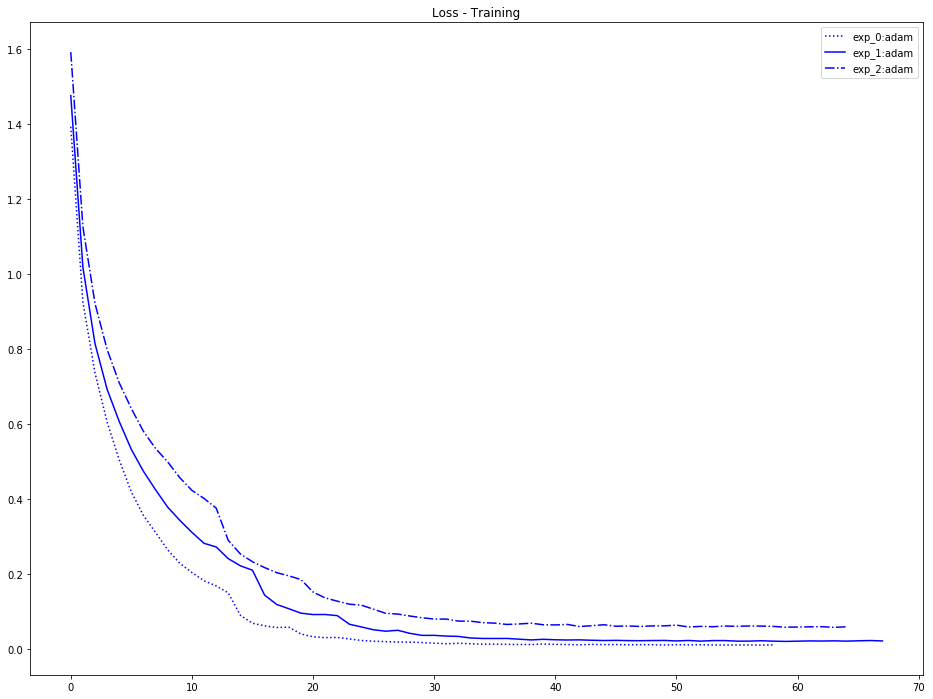

In [9]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(tra_loss["exp_0:sgd"][0])), tra_loss["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_1:sgd"][0])), tra_loss["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_2:sgd"][0])), tra_loss["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_3:sgd"][0])), tra_loss["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_4:sgd"][0])), tra_loss["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

# plt.plot(range(len(tra_loss["exp_0:rmsprop"][0])), tra_loss["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
# plt.plot(range(len(tra_loss["exp_1:rmsprop"][0])), tra_loss["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(tra_loss["exp_2:rmsprop"][0])), tra_loss["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(tra_loss["exp_3:rmsprop"][0])), tra_loss["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(tra_loss["exp_4:rmsprop"][0])), tra_loss["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(tra_loss["exp_0:adam"][0])), tra_loss["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(tra_loss["exp_1:adam"][0])), tra_loss["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
plt.plot(range(len(tra_loss["exp_2:adam"][0])), tra_loss["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(tra_loss["exp_3:adam"][0])), tra_loss["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(tra_loss["exp_4:adam"][0])), tra_loss["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(tra_loss["exp_0:adagrad"][0])), tra_loss["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_1:adagrad"][0])), tra_loss["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_2:adagrad"][0])), tra_loss["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_3:adagrad"][0])), tra_loss["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_4:adagrad"][0])), tra_loss["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Loss - Training")
plt.legend(loc="upper right")
plt.show()

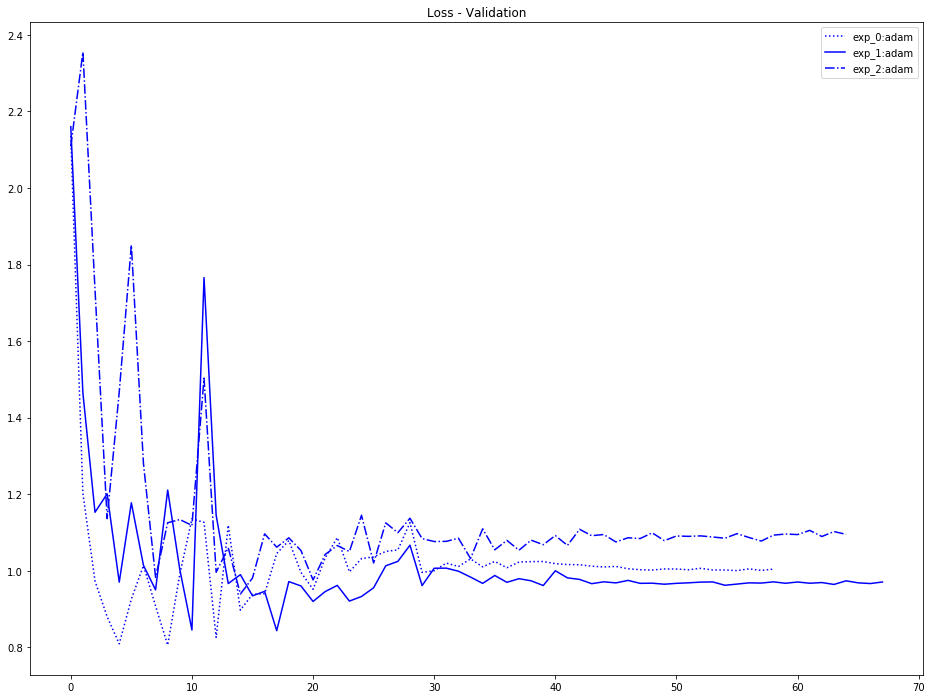

In [10]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(val_loss["exp_0:sgd"][0])), val_loss["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(val_loss["exp_1:sgd"][0])), val_loss["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(val_loss["exp_2:sgd"][0])), val_loss["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(val_loss["exp_3:sgd"][0])), val_loss["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(val_loss["exp_4:sgd"][0])), val_loss["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

# plt.plot(range(len(val_loss["exp_0:rmsprop"][0])), val_loss["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
# plt.plot(range(len(val_loss["exp_1:rmsprop"][0])), val_loss["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(val_loss["exp_2:rmsprop"][0])), val_loss["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(val_loss["exp_3:rmsprop"][0])), val_loss["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(val_loss["exp_4:rmsprop"][0])), val_loss["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(val_loss["exp_0:adam"][0])), val_loss["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(val_loss["exp_1:adam"][0])), val_loss["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
plt.plot(range(len(val_loss["exp_2:adam"][0])), val_loss["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(val_loss["exp_3:adam"][0])), val_loss["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(val_loss["exp_4:adam"][0])), val_loss["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(val_loss["exp_0:adagrad"][0])), val_loss["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_1:adagrad"][0])), val_loss["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_2:adagrad"][0])), val_loss["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_3:adagrad"][0])), val_loss["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_4:adagrad"][0])), val_loss["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Loss - Validation")
plt.legend(loc="upper right")
plt.show()

### Optimizer=Adam, batch_size=64, dropout=0.2, 4.882812731921149e-07 有較低的loss

## Plot accu history

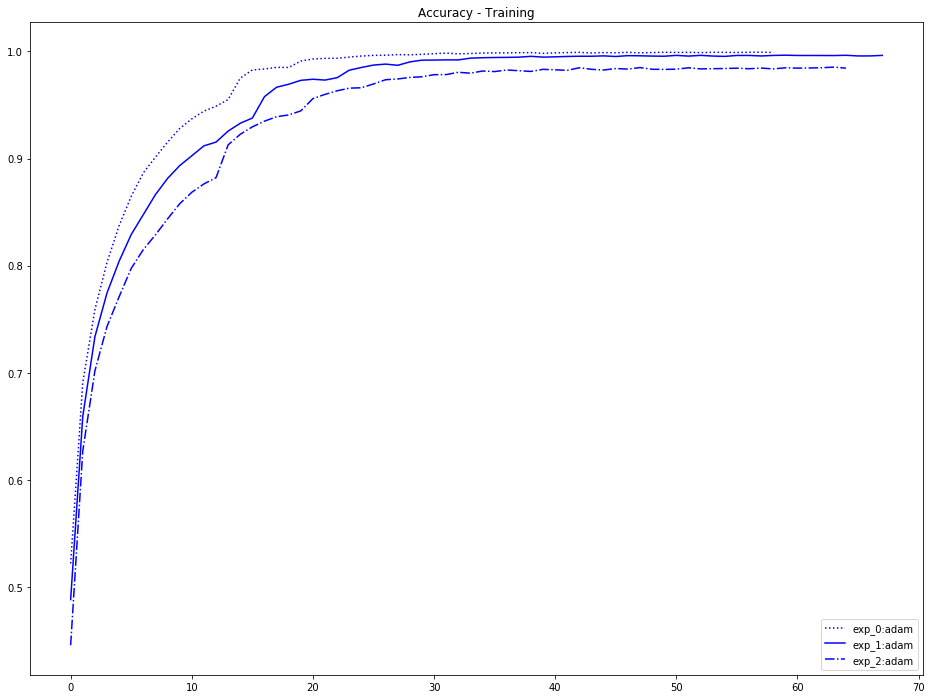

In [11]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(tra_accu["exp_0:sgd"][0])), tra_accu["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_1:sgd"][0])), tra_accu["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_2:sgd"][0])), tra_accu["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_3:sgd"][0])), tra_accu["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_4:sgd"][0])), tra_accu["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

# plt.plot(range(len(tra_accu["exp_0:rmsprop"][0])), tra_accu["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
# plt.plot(range(len(tra_accu["exp_1:rmsprop"][0])), tra_accu["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(tra_accu["exp_2:rmsprop"][0])), tra_accu["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(tra_accu["exp_3:rmsprop"][0])), tra_accu["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(tra_accu["exp_4:rmsprop"][0])), tra_accu["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(tra_accu["exp_0:adam"][0])), tra_accu["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(tra_accu["exp_1:adam"][0])), tra_accu["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
plt.plot(range(len(tra_accu["exp_2:adam"][0])), tra_accu["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(tra_accu["exp_3:adam"][0])), tra_accu["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(tra_accu["exp_4:adam"][0])), tra_accu["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(tra_accu["exp_0:adagrad"][0])), tra_accu["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_1:adagrad"][0])), tra_accu["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_2:adagrad"][0])), tra_accu["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_3:adagrad"][0])), tra_accu["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_4:adagrad"][0])), tra_accu["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Accuracy - Training")
plt.legend(loc="lower right")
plt.show()

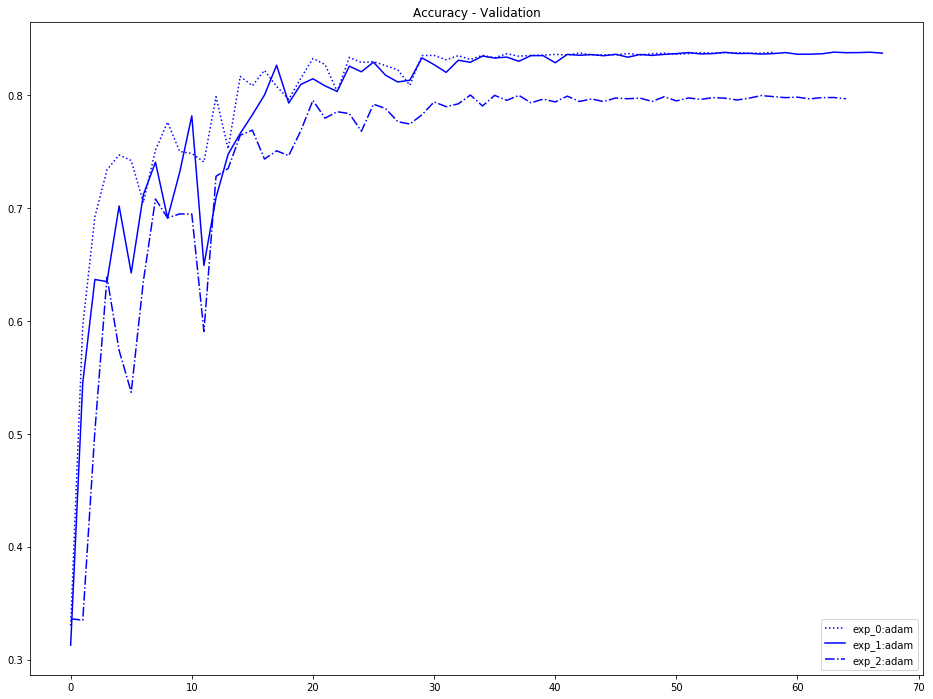

In [12]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(val_accu["exp_0:sgd"][0])), val_accu["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(val_accu["exp_1:sgd"][0])), val_accu["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(val_accu["exp_2:sgd"][0])), val_accu["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(val_accu["exp_3:sgd"][0])), val_accu["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(val_accu["exp_4:sgd"][0])), val_accu["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

# plt.plot(range(len(val_accu["exp_0:rmsprop"][0])), val_accu["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
# plt.plot(range(len(val_accu["exp_1:rmsprop"][0])), val_accu["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(val_accu["exp_2:rmsprop"][0])), val_accu["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(val_accu["exp_3:rmsprop"][0])), val_accu["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(val_accu["exp_4:rmsprop"][0])), val_accu["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(val_accu["exp_0:adam"][0])), val_accu["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(val_accu["exp_1:adam"][0])), val_accu["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
plt.plot(range(len(val_accu["exp_2:adam"][0])), val_accu["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(val_accu["exp_3:adam"][0])), val_accu["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(val_accu["exp_4:adam"][0])), val_accu["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(val_accu["exp_0:adagrad"][0])), val_accu["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_1:adagrad"][0])), val_accu["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_2:adagrad"][0])), val_accu["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_3:adagrad"][0])), val_accu["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_4:adagrad"][0])), val_accu["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Accuracy - Validation")
plt.legend(loc="lower right")
plt.show()

### Optimizer=Adam, batch_size=64, dropout=0.1, learning rate=9.765625463842298e-07.有較好的準確率

## Load back

In [13]:
# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 14s 1ms/step


In [14]:
## '-' solid line style
## '--' dashed line style
## '-.' dash-dot line style
## ':' dotted line style
## '.' point marker
## ',' pixel marker
## 'o' circle marker
## 'v' triangle_down marker
## '^' triangle_up marker
## '<' triangle_left marker
## '>' triangle_right marker
## '1' tri_down marker
## '2' tri_up marker
## '3' tri_left marker
## '4' tri_right marker
## 's' square marker
## 'p' pentagon marker
## '*' star marker
## 'h' hexagon1 marker
## 'H' hexagon2 marker
## '+' plus marker
## 'x' x marker
## 'D' diamond marker
## 'd' thin_diamond marker
## '|' vline marker
## '_' hline marker
## 
## 'b' blue
## 'g' green
## 'r' red
## 'c' cyan
## 'm' magenta
## 'y' yellow
## 'k' black
## 'w' white